In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from skimage.io import imsave
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import model_from_json

In [ ]:
# Get images
X = []
for filename in os.listdir('/content/drive/MyDrive/Betaversion/train/'):
    if filename.endswith(".jpg"):
        X.append(img_to_array(load_img('/content/drive/MyDrive/Betaversion/train/'+filename)))
X = np.array(X, dtype=float)

In [ ]:
# Set up training and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [ ]:
#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [ ]:
# Finish model
model.compile(optimizer='rmsprop', loss='mse')

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [ ]:
# Generate training data
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [ ]:
# Train model
TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=10000, epochs=1)
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1/1 [==============================] - 1s 697ms/step - loss: 0.0034
0.0033864425495266914


In [9]:
# Load black and white images
color_me = []
for filename in os.listdir('/content/drive/MyDrive/Betaversion/validate/'):
        color_me.append(img_to_array(load_img('/content/drive/MyDrive/Betaversion/validate/'+filename)))
color_me = np.array(color_me, dtype=float)
print(color_me.shape)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
print(color_me.shape)
color_me = color_me.reshape(color_me.shape+(1,))
print(color_me.shape)

(8, 256, 256, 3)
(8, 256, 256)
(8, 256, 256, 1)


In [ ]:
# Test model
output = model.predict(color_me)
output = output * 128

In [ ]:
# Output colorizations
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("/content/drive/MyDrive/Betaversion/result/img_"+str(i)+".png", lab2rgb(cur))

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Betaversion/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Betaversion/model.h5")
print("Saved model to disk")

Saved model to disk


In [5]:
# load json and create model
json_file = open('/content/drive/MyDrive/Betaversion/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Betaversion/model.h5")
print("Loaded model from disk")

Loaded model from disk


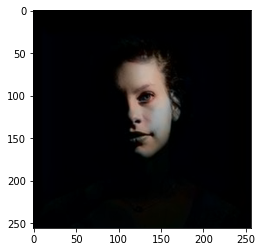

In [29]:
#my prediction
import matplotlib.pyplot as plt
%matplotlib inline
my_img = img_to_array(load_img("/content/drive/MyDrive/Betaversion/validate/0yTHvf.jpg"))
my_img = np.array(my_img, dtype=float)
my_img = rgb2lab(1.0/255*my_img)[:,:,0]
my_img = my_img.reshape(1, 256, 256, 1)
output = loaded_model.predict(my_img)
output *= 128
cur = np.zeros((256, 256, 3))
cur[:,:,0] = my_img[0][:,:,0]
cur[:,:,1:] = output[0]
result = lab2rgb(cur)
plt.imshow(result)
